# Spotted!

AC215: Productionizing AI (MLOps)

Sunil Chomal, Alex Coward, Olga Leushina, Jonathan Sessa

This notebook is for exploratory data analysis (EDA) of our datasets.

## Notebook Environment Setup

In [1]:
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import random as rn
import numpy as np
import pandas as pd
from scipy import stats as st

# File/Image Libraries
import os
import cv2
import pathlib
from glob import glob

# TensorFlow Libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, GlobalAvgPool2D, Dense, Add, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# SKLearn Dataset Management and Model Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Dask
import dask
import dask.dataframe as dd
import dask.delayed as delayed
from dask.diagnostics import ProgressBar

# Google libraries
from google.colab import auth

KeyboardInterrupt: ignored

In [ ]:
# Install GCS Fuse
!echo "deb https://packages.cloud.google.com/apt gcsfuse-$(lsb_release -c -s) main" | tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

In [ ]:
# Authenticate Google Cloud access using current account
auth.authenticate_user()

In [ ]:
# Create local directory and mount GCS buckets
!mkdir buckets
!gcsfuse buckets

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

In [ ]:
# See if/what GPU is running
!nvidia-smi

# Dataset Information

Our dataset combines images from the Standford Dogs dataset, Oxford Pets dataset, and Tsinghua Dogs dataset, resulting in ~96,000 images.

In [ ]:
# Get path to data bucket with images
images_data_path = os.path.join("buckets", "dog-breeds-original", "*")

# Get a list of paths to all images
image_files = glob(images_data_path)
print("Number of files:", len(image_files))

Number of files: 95999


In [ ]:
# Load CSV data from Google Bucket
csv_of_all_images = os.path.join("buckets/dog-breeds-224/csv", "data.csv")
df = dd.read_csv(csv_of_all_images, dtype={'filename': 'object', 'label': 'object'})

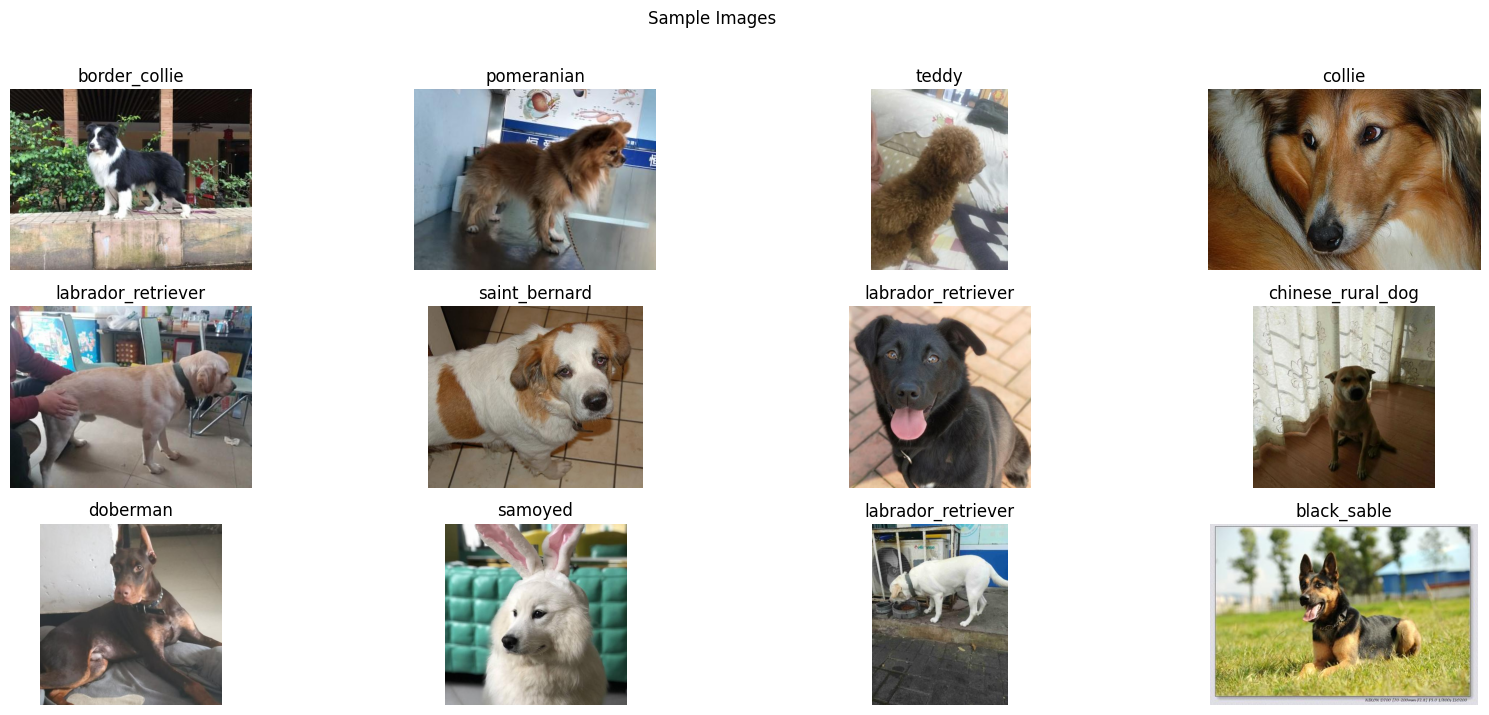

In [ ]:
# Generate a random sample of index numbers
image_samples = np.random.randint(0, high=len(image_files)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i, img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3, 4, i+1)
    axs.set_title(df.loc[img_idx].compute().label.item())

    # Read image
    filename = df.loc[img_idx].compute().filename.item()
    image = cv2.imread(os.path.join("buckets", "dog-breeds-original", filename))

    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

## Exploratory Data Analysis (Breeds)

To better understand the images contained in the dataset and what preprocessing would be required, we examined the dimensionality of the images and checked for potential outliers.

In [ ]:
# How many breeds are represented in dataset
breeds = np.unique(df['label'].compute())
print(f'Number of breeds: {len(breeds)}')

Number of breeds: 149


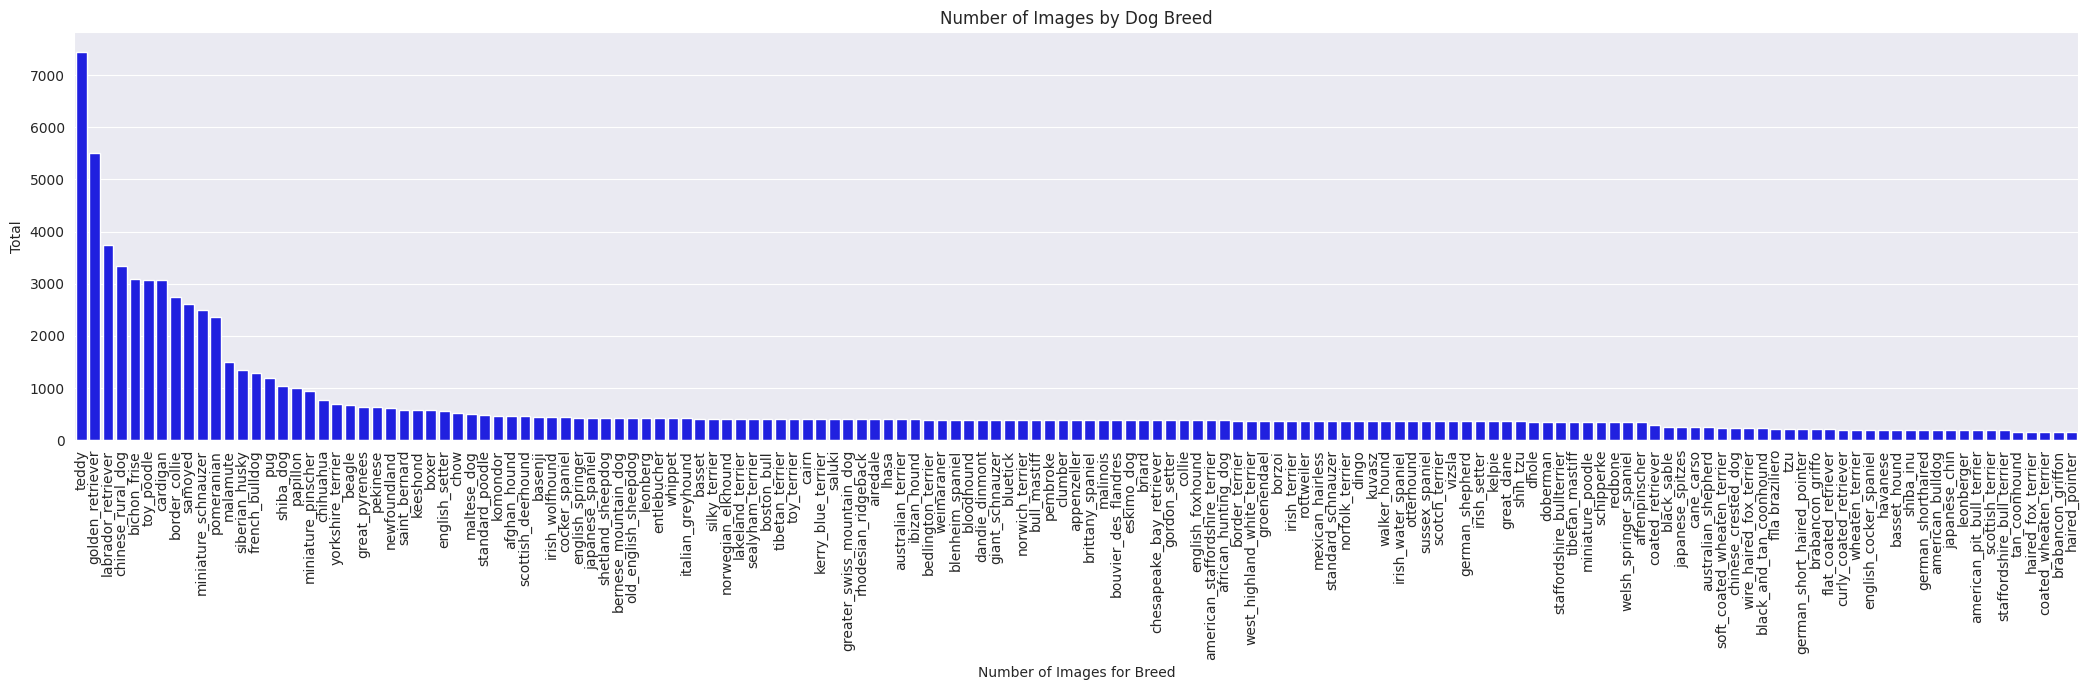

In [ ]:
breeds = df['label'].value_counts().compute().index.tolist()
count = df['label'].value_counts().compute()

all_breeds = pd.DataFrame({'Breed': breeds, 'Total': count})
all_breeds = all_breeds.sort_values(by='Total', ascending=False)

# Show graph for breed image frequency
fig, ax = plt.subplots(figsize=(21, 7))

sns.set_style("darkgrid")
sns.barplot(x="Breed", y="Total", data=all_breeds, color="b")

ax.set_xlabel('Number of Images for Breed')
ax.set_title('Number of Images by Dog Breed')
ax.tick_params(axis='x', rotation=90)

plt.tight_layout();

In [ ]:
count = df['label'].value_counts().compute()
print(count)

teddy                     7449
golden_retriever          5505
labrador_retriever        3751
chinese_rural_dog         3336
bichon_frise              3083
                          ... 
tan_coonhound              159
haired_fox_terrier         157
coated_wheaten_terrier     156
brabancon_griffon          153
haired_pointer             152
Name: label, Length: 149, dtype: int64


The most images are for the 'teddy' breed (a cross between .. and ..) with 7,449 images while the least images are for a 'haired_pointer' with only 152. The frequency appears to mirror popularity, with other popular breeds like Golden Retrievers and Labradors appearing at the top.

### Image Dimensions

Each image in the dataset is of a different dog (or dogs) with different background information and orientations.

In [ ]:
# Determine the widths and heights for all images
ds_iter = iter(ds)

widths, heights = [], []
min_width, min_height = 500, 500
max_width, max_height = 0, 0

# Determine largest width and height
for data in ds_iter:
    img = data[0]

    widths.append(img.shape[0])
    min_width = min(min_width, img.shape[0])
    max_width = max(max_width, img.shape[0])

    heights.append(img.shape[1])
    min_height = min(min_height, img.shape[1])
    max_height = max(max_height, img.shape[1])

print(f'Minimum Width: {min_width}; Minimum Height: {min_height}')
print(f'Maximum Width: {max_width}; Maximum Height: {max_height}')

Minimum Width: 103; Minimum Height: 97
Maximum Width: 2560; Maximum Height: 2740


In [ ]:
# Determine most common width and height
widths = np.array(widths)
heights = np.array(heights)

w_mode = st.mode(widths, keepdims=False)[0]
h_mode = st.mode(heights, keepdims=False)[0]

print(f'Most Common Width: {w_mode}')
print(f'Most Common Height: {h_mode}')

Most Common Width: 375
Most Common Height: 500


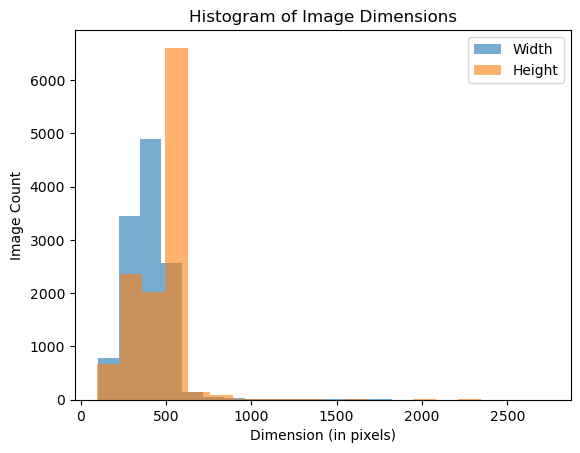

In [ ]:
# View distribution of image dimensions
plt.hist(widths, alpha=0.6, label='Width', bins=20)
plt.hist(heights, alpha=0.6, label='Height', bins=20)
plt.xlabel('Dimension (in pixels)')
plt.ylabel('Image Count')
plt.title('Histogram of Image Dimensions')
plt.legend();

The most common image dimensions are 375 pixels in width and 500 pixels in height. Depending on the model we choose, we will need to resize the images, but should use caution not to morph character features by changing the image aspect ratio.

## Data Preprocessing

### Image Resizing and Padding

Due to differences in image sizes, we must resize our images so they all have the same dimension. However, we also want to preserve the aspect ratio so we do not warp animal features. As a result, we apply padding to the images after resizing.

In [ ]:
# Preprocess dataset to resize and normalize images
IMG_SIZE = 224
PAD_SIZE = 224
BATCH_SIZE = 64

# Resize image, pad to desired size, then normalize
def preprocess(image, label):
    # Resize image then pad to reach desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], preserve_aspect_ratio=True)
    shape = tf.shape(image)
    top_pad = (PAD_SIZE - shape[0]) // 2
    left_pad = (PAD_SIZE - shape[1]) // 2
    image = tf.image.pad_to_bounding_box(image, top_pad, left_pad, PAD_SIZE, PAD_SIZE)

    # Convert value to float (for pre-processing)
    image = tf.cast(image, tf.float32)

    # One-hot categorical encoding for labels
    label = tf.one_hot(label, NUM_CLASSES)

    return image, label

## TFRecords Data


Loading Data from TFRecords file:

In [ ]:
num_classes = 149
num_channels = 3
image_height = 224
image_width = 224

batch_size = 128


# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string)
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])

  # Label
  label = tf.cast(parsed_example['label'], tf.uint8)
  #label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Read the tfrecord files
tfr_data_path = os.path.join("buckets", "dog-breeds-224_tfr")
test_tfrecord_files = tf.data.Dataset.list_files(tfr_data_path + '/test*')

#############
# Test data
#############
test_data = test_tfrecord_files.flat_map(tf.data.TFRecordDataset)
test_data = test_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

print("test_data", test_data)

test_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


In [ ]:
def parse_fn(serialized):
    # Define the features we want to extract
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)
    }

    # Parse the serialized record using the feature dictionary
    parsed = tf.io.parse_single_example(serialized, features)

    return parsed

dataset = test_tfrecord_files.flat_map(tf.data.TFRecordDataset)

# Apply the parsing function to each record in the dataset
parsed_dataset = dataset.map(parse_fn)

# Inspect the first 5 records in the dataset
for record in parsed_dataset.take(1):

    print(record['label'])

tf.Tensor(b'brittany_spaniel', shape=(), dtype=string)


In [ ]:
for record in test_data.take(5):
  print(record)

UnimplementedError: ignored

In [ ]:
tfds.disable_progress_bar()

# Create a 70/15/15 train/validation/test split
train_ds, val_ds, test_ds = tfds.load('stanford_dogs',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True,
                                      as_supervised=True)

train_ds = (
    train_ds
    .cache()
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .cache()
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

For this example, we chose to use EfficientNetV2 B0 as our base model. EfficientNetV2 has shown a high level of classification accuracy when compared to other models, but with a fraction of the parameters. The smaller size of EfficientNet also allows us to train faster (which allows for easier experimentation and hyperparameter tuning).

In [ ]:
# Load EfficientNet V2 B0 as our base model
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    include_preprocessing=False
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

We freeze the weights of the base model, and apply a Global Average Pooling layer to reduce the dimensionality of the model's output. We then use a dense layer with the same number of classes we are trying to predict and softmax activation to train the model to generate a prediction probability for each breed.

In [ ]:
# Input Layer
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
baseline_model = keras.Model(inputs=inputs, outputs=outputs, name='baseline_model')

# Output the model summary
baseline_model.summary()

# Compile the model
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
)

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                    

We trained our model using Google Colab and saved the model weights and history for easier re-loading and sharing information among group members.

In [ ]:
# Adapted from CS109B: HW4 Solution Notebook

if USE_SAVED_MODEL:
    # Load saved weights and model history
    baseline_model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        baseline_model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    baseline_model_history = baseline_model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        baseline_model_history = baseline_model_history.history
        pickle.dump(baseline_model_history, filehandler)

    # Save model and weights for future use
    baseline_model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

Epoch 1/10
132/132 [==============================] - 108s 791ms/step - loss: 1.4687 - accuracy: 0.6286 - val_loss: 1.2649 - val_accuracy: 0.7750
Epoch 2/10
132/132 [==============================] - 105s 796ms/step - loss: 0.4337 - accuracy: 0.8685 - val_loss: 0.6839 - val_accuracy: 0.7989
Epoch 3/10
132/132 [==============================] - 106s 801ms/step - loss: 0.2418 - accuracy: 0.9393 - val_loss: 0.6084 - val_accuracy: 0.8056
Epoch 4/10
132/132 [==============================] - 116s 881ms/step - loss: 0.1454 - accuracy: 0.9701 - val_loss: 0.6058 - val_accuracy: 0.8039
Epoch 5/10
132/132 [==============================] - 115s 869ms/step - loss: 0.0939 - accuracy: 0.9851 - val_loss: 0.6121 - val_accuracy: 0.8044
Epoch 6/10
132/132 [==============================] - 112s 850ms/step - loss: 0.0652 - accuracy: 0.9933 - val_loss: 0.6202 - val_accuracy: 0.8050
Epoch 7/10
132/132 [==============================] - 115s 869ms/step - loss: 0.0482 - accuracy: 0.9969 - val_loss: 0.6295 -

In [ ]:
# Helper function for plotting training history
# Adapted from CS109B: Lab 8 Notebook

def plot_history(model_history, title):
    # plot 'Loss'
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(model_history['loss'], label='train')
    axs[0].plot(model_history['val_loss'], label='validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    best_loss = np.nanmin(model_history['val_loss'])
    axs[0].axvline(np.nanargmin(model_history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    axs[0].legend()
    axs[0].set_title('Loss')

    # in case the Network has multiple outputs
    train_accuracy = []
    val_accuracy = []

    for cur_history in model_history:
        if 'accuracy'in cur_history:
            if 'val' in cur_history:
                val_accuracy.append(model_history[cur_history])
            else:
                train_accuracy.append(model_history[cur_history])

    train_accuracy = np.mean(np.array(train_accuracy), axis=0)
    val_accuracy = np.mean(np.array(val_accuracy), axis = 0)

    # plot 'Accuracy'
    axs[1].plot(train_accuracy, label='train')
    axs[1].plot(val_accuracy, label='validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    best_accuracy = np.nanmax(val_accuracy)
    axs[1].axvline(np.nanargmax(val_accuracy),
                c='k', ls='--',
                label=f'best val accuracy = {best_accuracy:.5f}')
    axs[1].legend()
    axs[1].set_title('Accuracy')
    plt.suptitle(title)

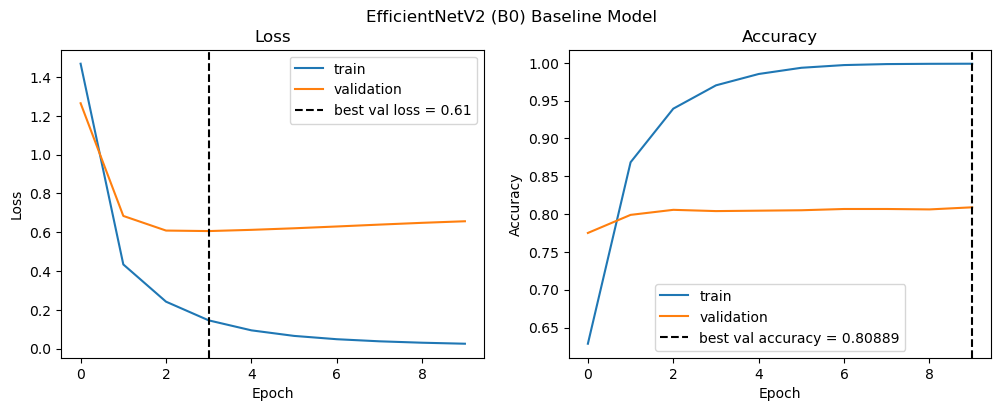

In [ ]:
# Plot the history of model training
plot_history(baseline_model_history, title = 'EfficientNetV2 (B0) Baseline Model')

After the first few epochs, validation accuraccy levels off. This can likely be attributed to not having any data augmentation and the model quickly learning all it can from the training data. Given the complexity of the problem, an accuracy of about 80% sounds good and shows that EfficientNet is likely a good baseline model to use and work from.

### Baseline Model Evaluation

After training the baseline model, we want to understands its accuracy when making predictions on the test dataset:

In [ ]:
# Get model predictions on test set
y_pred = baseline_model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 16s 557ms/step


In [ ]:
# Baseline Model accuracy
print(f"Model testing accuracy: {accuracy_score(y_true, y_pred)}")

Model testing accuracy: 0.81


## Next Steps

To improve our model performance, we will include additional data as well as data augmentation using random transformations to increase the variety of training images.

We will also explore other potential models, as well as do additional training and fine-tuning on the selected model.